## Nonparametric Density Estimation with `condensier`

## Lab 07 for PH 290: Targeted Learning in Biomedical Big Data

### Author: [Nima Hejazi](https://nimahejazi.org)

### Date: 28 February 2018

# I. Nonparametric Density Estimation

For a moment, we will go back to simple data structures: we have observations which are realizations of univariate random variables,
$$X_1, \ldots, X_n \sim F,$$
where $F$ denotes an unknown cumulative distribution function (CDF). The goal is to estimate the distribution $F$. In particular, we are interested in estimating the density $f = F′$ , assuming that it exists.

### Histograms

The histogram is the oldest and most popular density estimator. We need to specify an "origin" $x_0$ and the class width $h$ for the specifications of the intervals:
$$I_j =(x_0 + j \cdot h,x_0 + (j + 1) \cdot h),  (j = \ldots, −1, 0, 1, \ldots)$$

### The Naïve Kernel Estimator

$$\hat{f}(x) = \frac{1}{nh} \sum_{i = 1}^{n} w \left(\frac{x - X_i}{h}\right),$$
where $w(x) = \frac{1}{2}, \mid X \mid \leq 1; 0, \text{otherwise}$. This is merely a simple weight function that places a rectangular box around each interval $(x - h, x + h)$.

By replaceing $w$ with a generalized smooth kernel function, we get the definition of the _kernel density estimator_:
$$\hat{f}(x) = \frac{1}{nh} \sum_{i = 1}^{n} K \left(\frac{x - X_i}{h}\right),$$
where $$K(x) \geq 0, \int_{-\infty}^{\infty} K(x) dx = 1, K(x) = K(-x).$$

The positivity of the kernel function $K(\cdot)$ guarantees a positive density estimate $f(\cdot)$ and the normalization $K(x)dx = 1$ implies that $f(x)dx = 1$, which is necessary for $f(\cdot)$ to be a density.
Typically, the kernel function $K(\cdot)$ is chosen as a probability density which is symmetric around $0$. Additionally, the smoothness of $f(\cdot)$ is inherited from the smoothness of the kernel.

In the above definition, we leave the bandwidth $h$ as a _tuning parameter_, which can be chosen so as to minimize an arbitrary distance metric that ensures the estimated function is optimal, given the available data. For large bandwidth $h$, the estimate $f(x)$ tends to be very slowly varying as a function of $x$, while small bandwidths will produce a more variable function estimate.

### The Bandwidth $h$

The bandwidth h is often also called the "smoothing parameter". It should be clear that for $h \to 0$, we will have spikes at every observation $X_i$, whereas $f(\cdot) = fh(\cdot)$ becomes smoother as $h$ is increasing. In the above, we use a global bandwidth, which we might choose optimally using cross-validation, but, we can also use variable bandwidths (locally changing bandwidths $h(x)$), with the general idea her being to use a large bandwidth for regions where the data is sparse. With respect to the _bias-variance tradeoff_: **the (absolute value of the) bias of $\hat{f}$ increases and the variance of $\hat{f}$ decreases as $h$ increases**.

## (!) Exercise

Propose a specific approach to choosing a locally changing bandwidth $h(x)$ for kernel density estimation. For your chosen approach, provide a single advantage and a single disadvantage for your given approach.

# II. Density Estimation with `condensier`

First, let's load the packages we'll be using and some core project management tools.

In [1]:
library(usethis)
usethis::create_project(".")
library(here)
library(tidyverse)
library(data.table)
library(simcausal)
library(condensier)
library(data.table)
library(sl3)

Changing active project to lab_07
✔ Writing a sentinel file '.here'
● Build robust paths within your project via `here::here()`
● Learn more at https://krlmlr.github.io/here/


here() starts at /Users/nimahejazi/Dropbox/UC_Berkeley-grad/teaching/tlbbd-labs/lab_07
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.3.0     
✔ readr   1.1.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

condensier
The condensier package is still in beta testing. Interpret results with caution.


We begin by simulating a simple data set and illustrating a simple execution of how to use `condensier` to perform conditional density estimation:

In [2]:
library("simcausal")
D <- DAG.empty()
D <- D + node("W1", distr = "rbern", prob = 0.5) +
         node("W2", distr = "rbern", prob = 0.3) +
         node("W3", distr = "rbern", prob = 0.3) +
         node("A", distr = "rnorm", mean = (0.98 * W1 + 0.58 * W2 + 0.33 * W3), sd = 1)
D <- set.DAG(D, n.test = 10)

...automatically assigning order attribute to some nodes...
node W1, order:1
node W2, order:2
node W3, order:3
node A, order:4


using the following vertex attributes: 
120.8NAdarkbluenone0
using the following edge attributes: 
0.50.40.8black1


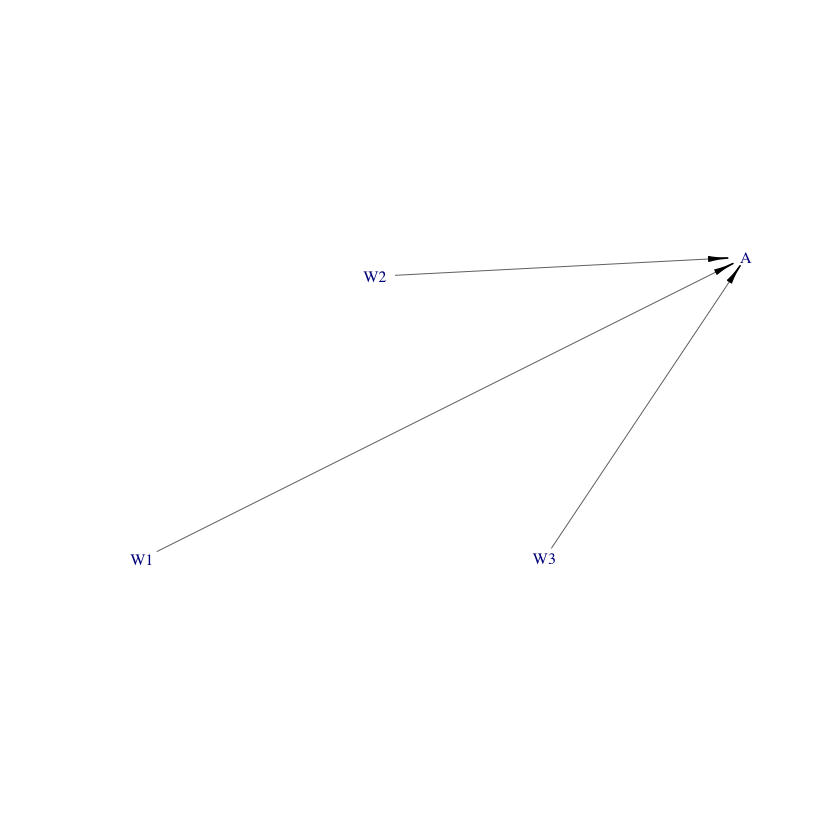

In [3]:
plotDAG(D, xjitter = 0.3, yjitter = 0.04, edge_attrs = list(width = 0.5, arrow.width = 0.4, arrow.size = 0.8), vertex_attrs = list(size = 12, label.cex = 0.8))

Now that we've taken a look at the structure of the data-generating process (the DAG), let's generate some data and take a quick look at the data set:

In [4]:
data_O <- as.data.table(sim(D, n = 10000, rndseed = 12345))
head(data_O)

simulating observed dataset from the DAG object


ID,W1,W2,W3,A
1,1,0,0,0.7075761
2,1,0,1,1.5157866
3,1,1,1,0.8108074
4,1,1,1,2.4268503
5,0,0,0,-0.8857180
6,0,0,1,-0.3614194


In [5]:
newdata <- data_O[seq_len(100), c("W1", "W2", "W3", "A"), with = FALSE]

Now that we've generate some data, we can try to estimate the conditional distribution $P(A \mid W)$, using the observed data.

In [6]:
dens_fit <- fit_density(
    X = c("W1", "W2", "W3"), 
    Y = "A", 
    input_data = data_O, 
    nbins = 40, 
    bin_method = "equal.mass",
    bin_estimator = speedglmR6$new())

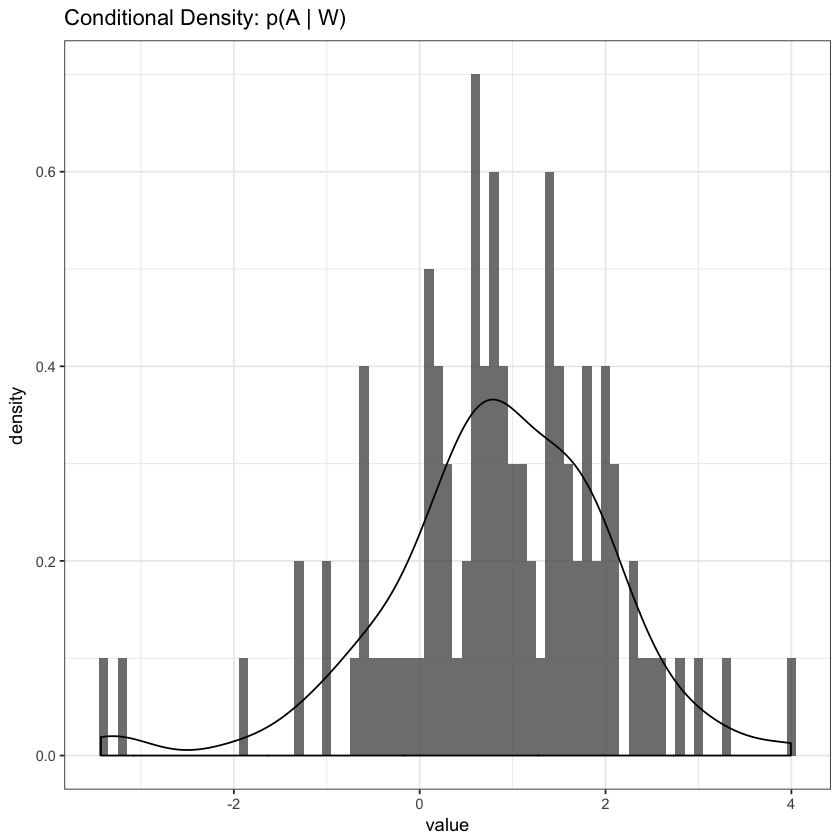

In [7]:
preds_1 <- sample_value(model_fit = dens_fit, newdata = newdata)

p1_A_given_W <- as_tibble(preds_1) %>%
  ggplot(., aes(x = value)) +
  geom_histogram(aes(y = ..density..), binwidth = 0.1, alpha = 0.8,
                 position = "identity") +
  geom_density(alpha = 0.2) +
  ggtitle("Conditional Density: p(A | W)") + theme_bw()

p1_A_given_W

In [8]:
dens_fit <- fit_density(
    X = c("W1", "W2", "W3"), 
    Y = "A", 
    input_data = data_O, 
    nbins = 40, 
    bin_method = "equal.len",
    bin_estimator = speedglmR6$new())

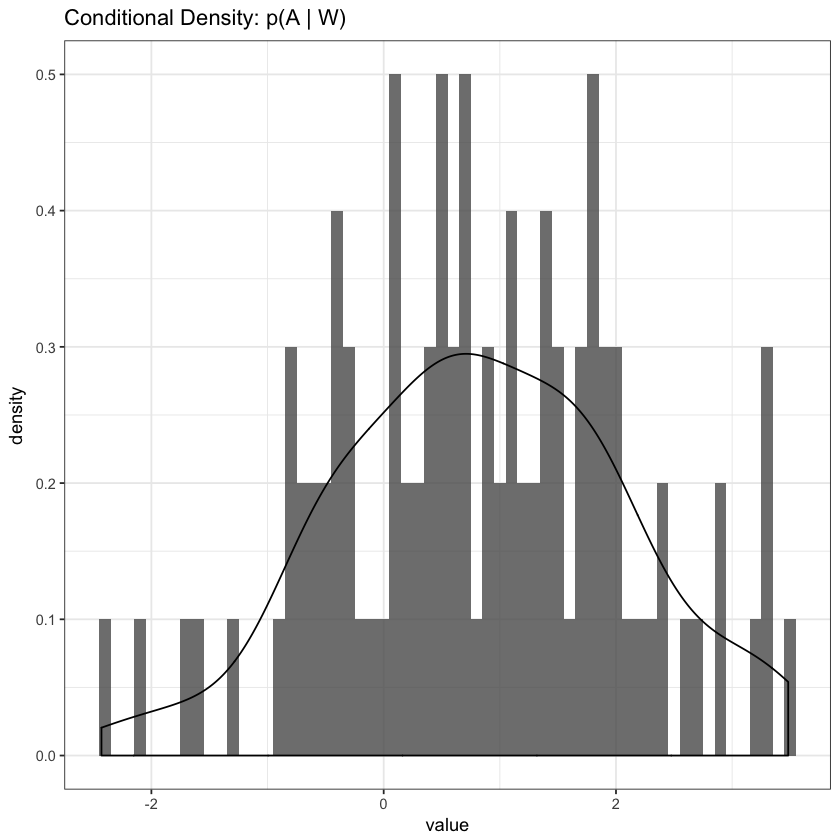

In [9]:
preds_2 <- sample_value(model_fit = dens_fit, newdata = newdata)

p2_A_given_W <- as_tibble(preds_2) %>%
  ggplot(., aes(x = value)) +
  geom_histogram(aes(y = ..density..), binwidth = 0.1, alpha = 0.8,
                 position = "identity") +
  geom_density(alpha = 0.2) +
  ggtitle("Conditional Density: p(A | W)") + theme_bw()

p2_A_given_W

In [10]:
dens_fit <- fit_density(
    X = c("W1", "W2", "W3"), 
    Y = "A", 
    input_data = data_O, 
    nbins = 25, 
    bin_method = "dhist",
    bin_estimator = speedglmR6$new())

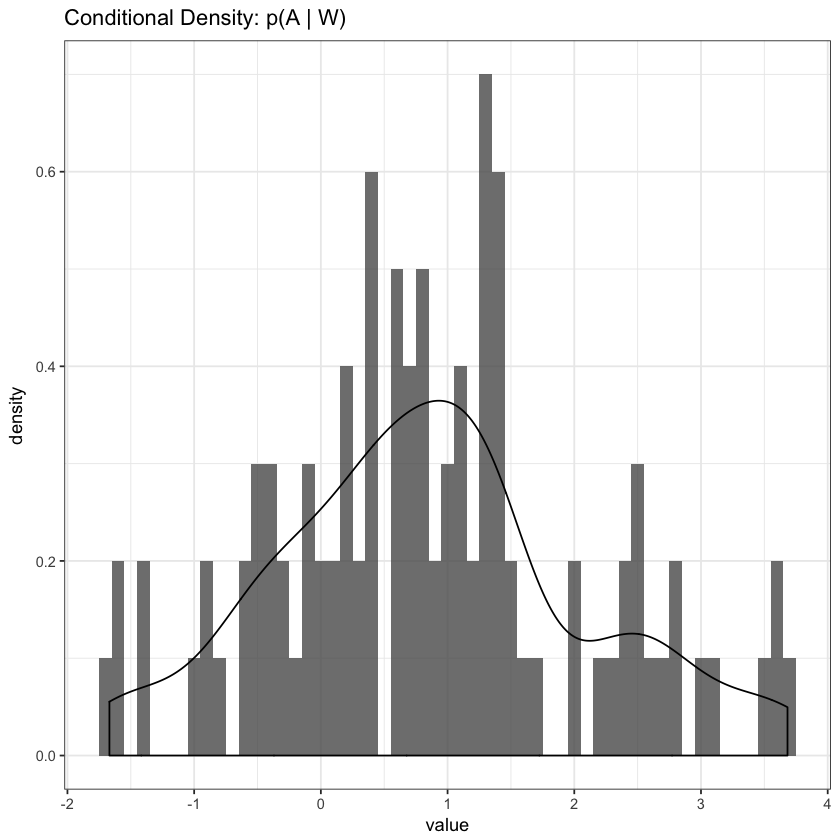

In [11]:
preds_3 <- sample_value(model_fit = dens_fit, newdata = newdata)

p3_A_given_W <- as_tibble(preds_3) %>%
  ggplot(., aes(x = value)) +
  geom_histogram(aes(y = ..density..), binwidth = 0.1, alpha = 0.8,
                 position = "identity") +
  geom_density(alpha = 0.2) +
  ggtitle("Conditional Density: p(A | W)") + theme_bw()

p3_A_given_W